# LSTM

In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
import pandas as pd
import sklearn
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.utils import to_categorical
#from tensorflow.keras import regularizers


### Load data

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2020-08-14 14:52:06--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolviendo storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:4012:808::2010, 2607:f8b0:4012:805::2010, 2607:f8b0:4012:80b::2010, ...
Conectando con storage.googleapis.com (storage.googleapis.com)[2607:f8b0:4012:808::2010]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 238942690 (228M) [application/octet-stream]
Grabando a: “/tmp/training_cleaned.csv”

/tmp/training_clean 100%[===================>] 227.87M  3.43MB/s    en 63s     

2020-08-14 14:53:09 (3.62 MB/s) - “/tmp/training_cleaned.csv” guardado [238942690/238942690]



In [2]:
df = pd.read_csv("/tmp/training_cleaned.csv", names = ["Class","Id","Time","NQ","User","Text"])

In [3]:
df[['Class','Text']]

,Class,Text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [4]:
df = sklearn.utils.shuffle(df)

In [5]:
df['Class'] = df['Class'].replace(4, 1)

In [6]:
df = df[['Class','Text']]

### Tokenizing and padding data 

In [7]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="<UNK>")
tokenizer.fit_on_texts(df["Text"])

In [19]:
training_inputs = tf.keras.preprocessing.sequence.pad_sequences(
                            tokenizer.texts_to_sequences(df["Text"][:int(1600000*.8)]),
                            maxlen=16,
                            truncating="post",
                            padding="post")
testing_inputs = tf.keras.preprocessing.sequence.pad_sequences(
                            tokenizer.texts_to_sequences(df["Text"][int(1600000*.8):]),
                            maxlen=16,
                            truncating="post",
                            padding="post")

## Model

In [49]:
inputs = tf.keras.Input((16,))
x = tf.keras.layers.Embedding(10000,200,input_length=16)(inputs)
x = tf.keras.layers.LSTM(30)(x)
x = tf.keras.layers.Dense(20,activation="relu")(x)
x = tf.keras.layers.Dense(10,activation="relu")(x)
x = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs,outputs=x)
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 16, 200)           2000000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 30)                27720     
_________________________________________________________________
dense_16 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_17 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 11        
Total params: 2,028,561
Trainable params: 2,028,561
Non-trainable params: 0
_________________________________________________

In [50]:
model.compile(loss = 'binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [51]:
history = model.fit(training_inputs,
          df["Class"][:int(1600000*.8)], 
          validation_data=(testing_inputs,df["Class"][int(1600000*.8):]),
          epochs=3,
          batch_size=int(1600000*.8/20)
         )

Epoch 1/3
20/20 [==============================] - 87s 4s/step - loss: 0.6865 - accuracy: 0.5862 - val_loss: 0.6680 - val_accuracy: 0.6784
Epoch 2/3
20/20 [==============================] - 104s 5s/step - loss: 0.5935 - accuracy: 0.7232 - val_loss: 0.5152 - val_accuracy: 0.7553
Epoch 3/3
20/20 [==============================] - 112s 6s/step - loss: 0.4824 - accuracy: 0.7744 - val_loss: 0.4666 - val_accuracy: 0.7818


In [52]:
history.history

{'loss': [0.6865171194076538, 0.593518078327179, 0.48239657282829285],
 'accuracy': [0.5862234234809875, 0.7231851816177368, 0.7744452953338623],
 'val_loss': [0.6680416464805603, 0.5151679515838623, 0.4666077196598053],
 'val_accuracy': [0.6784312725067139, 0.7553062438964844, 0.7818187475204468]}

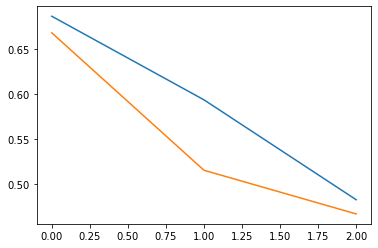

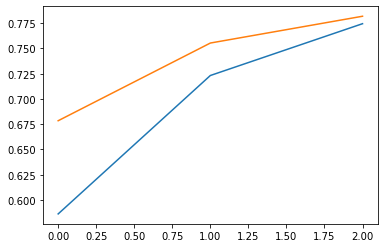

In [53]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.show()
plt.plot(history.history['accuracy'],label="accuracy")
plt.plot(history.history['val_accuracy'],label="val_accuracy")
plt.show()

In [54]:
e = model.layers[1]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 200)


In [35]:
import io
tokens_to_words = dict([(val,key)for (key, val) in tokenizer.word_index.items()])
out_v = io.open('LSTM(result)/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('LSTM(result)/meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, 10000):
    word = tokens_to_words[word_num]
    embeddings = weights[word_num]
    
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()